# TopoCluster Regression: IQR Comparison (for energy *scaling* networks)

This notebook makes plots of energy resolution (defined by the interquartile range for distributions of the ratio of predicted energy to calibration hits), specifically for regression networks that predict a *corrective factor* with which to multiply the reco energy (to get a predicted energy). This is in contrast with our "typical" regression networks that directly try to predict the energy itself.

In [1]:
# source & subdir -- used to specify a set of networks that were trained with particular data & settings
source = 'pion'
subdir = 'pion2'

#### 1) Initial setup

In [2]:
# Import some basic libraries.
import sys, os, glob, pathlib
import numpy as np
import h5py as h5
import ROOT as rt # used for plotting
from numba import jit
    
# Import our resolution utilities
path_prefix = os.getcwd() + '/../'
if(path_prefix not in sys.path): sys.path.append(path_prefix)
from util import plot_util       as pu
from util import ml_util         as mu
from util import qol_util        as qu

# regression-specific imports
from util.regression import plot_util as rpu

rt.gStyle.SetOptStat(0)
# use our custom dark style for plots
plotstyle = qu.PlotStyle('dark')
plotstyle.SetStyle() # still need to manually adjust legends, paves

plotpath = os.getcwd() + '/Plots/{}/'.format(subdir)
modelpath = os.getcwd() + '/Models/{}/'.format(subdir)
paths = [plotpath, modelpath]
for path in paths:
    try: os.makedirs(plotpath)
    except: pass

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]
cell_shapes = {layers[i]:(len_eta[i],len_phi[i]) for i in range(len(layers))}

Welcome to JupyROOT 6.24/00


#### 2) Get Results

Rather than get the data, networks & re-evaluate everything, we're just going to load network outputs from HDF5 files that were saved during training & evaluation in our training notebook. This means that this notebook should run rather quickly (and not require GPU resources for quick network evaluation). Just make sure not to throw out the HDF5 files with results, otherwise you will have to remake them with the other notebook.

In [3]:
# list of networks to evaluate
models = ['all','simple','simple_cnn','split_emb_cnn']
colors = [rt.kRed, rt.kYellow, plotstyle.main, rt.kGreen, plotstyle.text]
result_files = {
    model:{
        'pp':h5.File(modelpath + '{}/{}_charged_output.h5'.format(model,model),'r'),
        'p0':h5.File(modelpath + '{}/{}_neutral_output.h5'.format(model,model),'r'),
    }
    for model in models
}

results = {
    model:{
        key:{
            name:file[name][file['test'][:]]
            for name in ['output','truth','reco']
        }
        for key,file in result_files[model].items()
    }
    for model in models
}

for fdict in result_files.values():
    for key,val in fdict.items():
        val.close()

#### 3) Make IQR plots (with ROOT)

**TODO**: Try using some of our custom (matplotlib-based) functions. Maybe the plots will look nice?

In [4]:
nbins = 40
x_range = (0.,800.)

iqr_hists = {
    model:{
        key: rpu.IqrPlot(data['output'] * data['reco'],data['truth'], nbins = nbins, x_range=x_range, normalize=True)
        for key,data in results[model].items()
    }
    for model in models
}

# add in the reco info
iqr_hists['reco'] = {
    key: rpu.IqrPlot(data['reco'],data['truth'], nbins = nbins, x_range=x_range)
    for key,data in results[models[0]].items()
}

plot_keys = models
plot_keys = ['reco'] + models # make sure reco is plotted first with orange

if(plotstyle.curve not in colors): colors = [plotstyle.curve] + colors

Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/regression2/Plots/pion2/iqr_pp.png has been created
Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/regression2/Plots/pion2/iqr_p0.png has been created


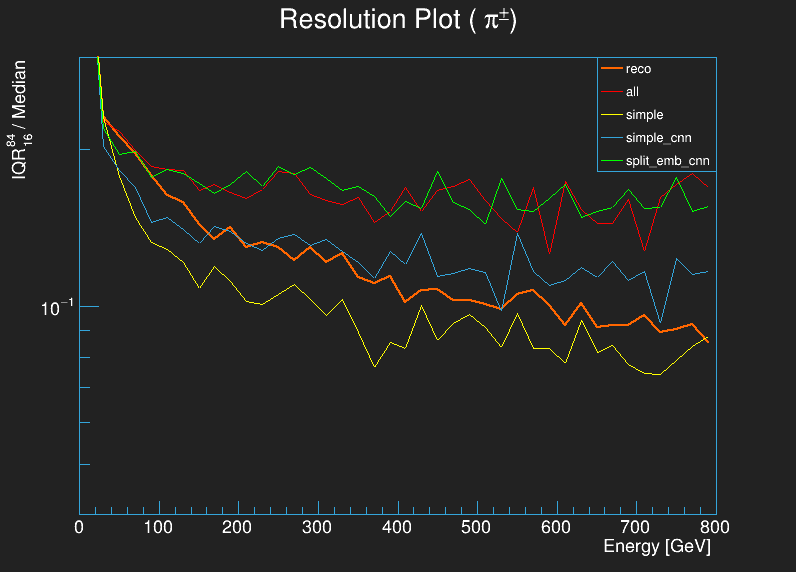

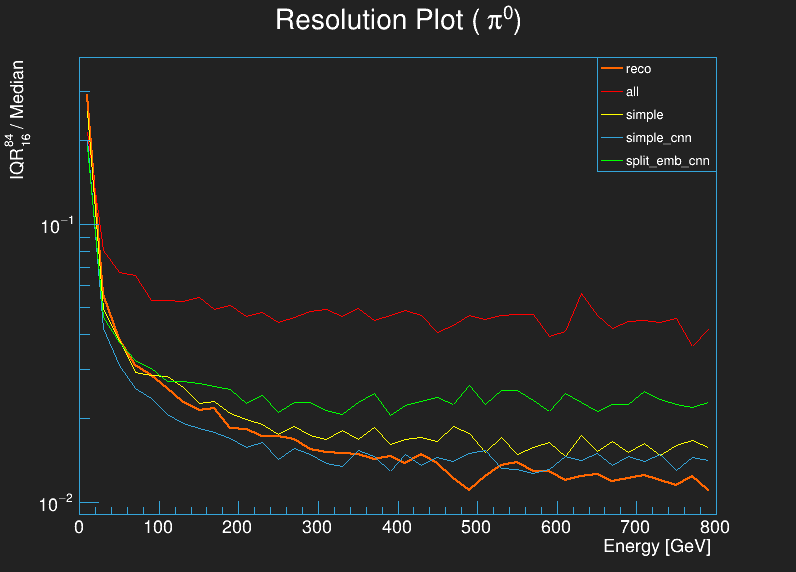

In [5]:
canvases = []
stacks = []
legends = []

pname = {
    'pp':'#pi^{#pm}',
    'p0':'#pi^{0}'
}

ranges = {
    'pp':(4.0e-2,3.0e-1),
    'p0':(9.0e-3,4.0e-1)
}

for pkey in pname.keys():

    c = rt.TCanvas(qu.RN(),'c1',800,600)
    stack = rt.THStack()
    leg = rt.TLegend(0.75,0.7,0.9,0.9)
    leg.SetTextColor(plotstyle.text)

    for i,model in enumerate(plot_keys):
        iqr_hists[model][pkey].SetLineColor(colors[i])
        if(model == 'reco'): iqr_hists[model][pkey].SetLineWidth(2)
        stack.Add(iqr_hists[model][pkey])
        leg.AddEntry(iqr_hists[model][pkey],model,'l')

    stack.Draw('NOSTACK HIST L') # use 'NOSTACK HIST' for more accurate (but harder-to-read) version, the curves are hiding binning
    
    stack.SetMinimum(ranges[pkey][0])
    stack.SetMaximum(ranges[pkey][1])
    rt.gPad.SetLogy()

    stack.SetTitle('Resolution Plot ({});Energy [GeV];{} / Median'.format(pname[pkey], 'IQR_{16}^{84}'))
    leg.Draw()
    c.Draw()
    
    c.SaveAs(plotpath + 'iqr_{}.png'.format(pkey))
    
    stacks.append(stack)
    canvases.append(c)
    legends.append(leg)

While the results are not exactly impressive, it looks like the resolution is better here than in our standard regression, i.e. it seems better to use a network that tries to predict $E_\text{calib}^\text{tot} / E_\text{reco}$ instead of directly predicting $E_\text{calib}^\text{tot}$.

It looks like for $\pi^\pm$ (which is the harder case), our `simple` and `simple_cnn` have comparable or better resolution than the reco energy for lower truth energies (i.e. for truth energy less than $200 \; \text{[GeV]}$).

For $\pi^0$, where the resolution is much better to begin with, our `spit_emb_cnn` offers somewhat better resolution at very low energies (i.e. truth energy less than $50 \; \text{[GeV]}$), but otherwise the reco energy is outperforming all of our networks. Which is sort of disappointing -- we're trying to correct the energy, and yet end up with worse resolution.

While it's not our primary concern, let's also look at the average predicted energy. Maybe the resolution (IQR) suffers in some cases, but is the network at least predicting the right energy on average? Since these are 2D plots based on how we do them, we can't do an overlay. Instead I'll just make the plots for some select methods.

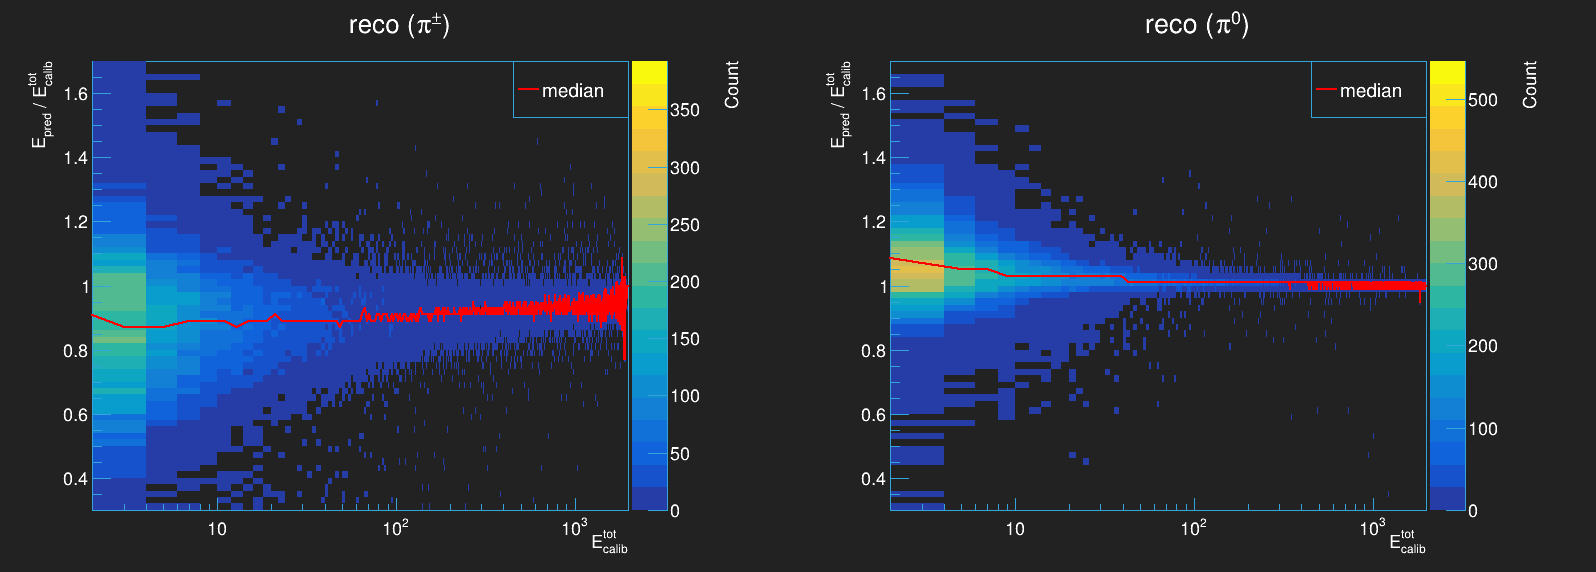

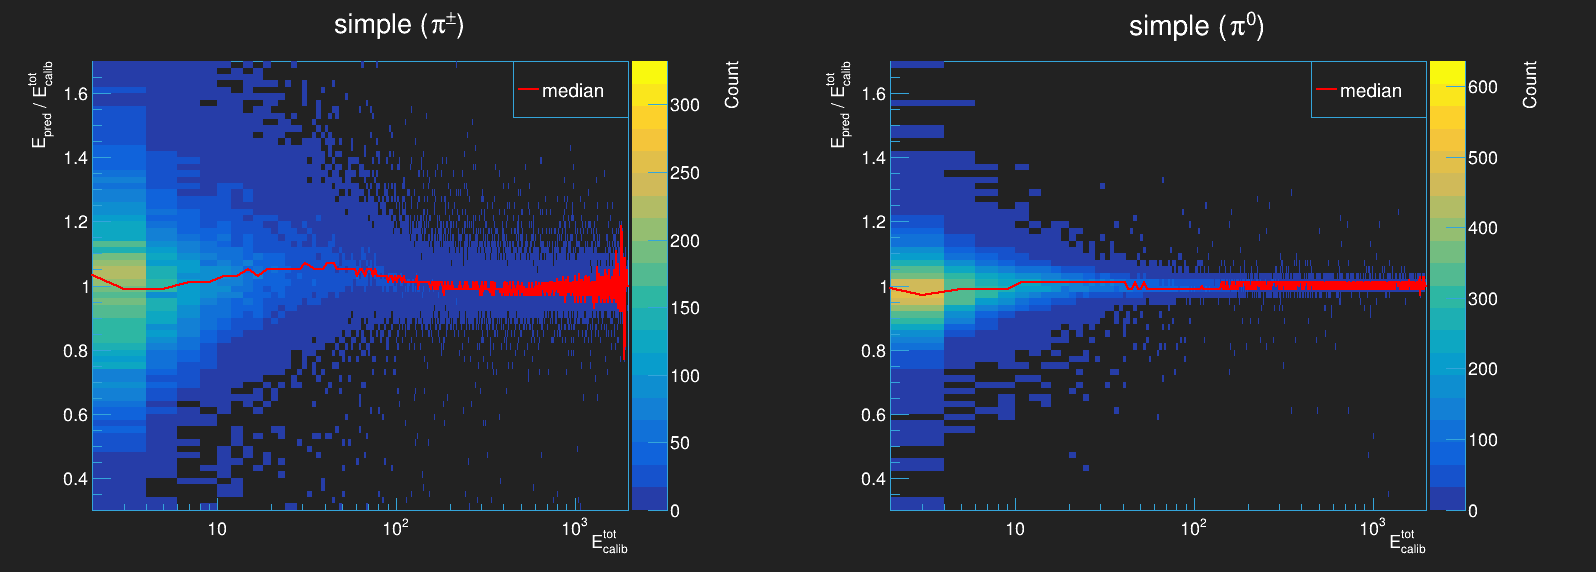

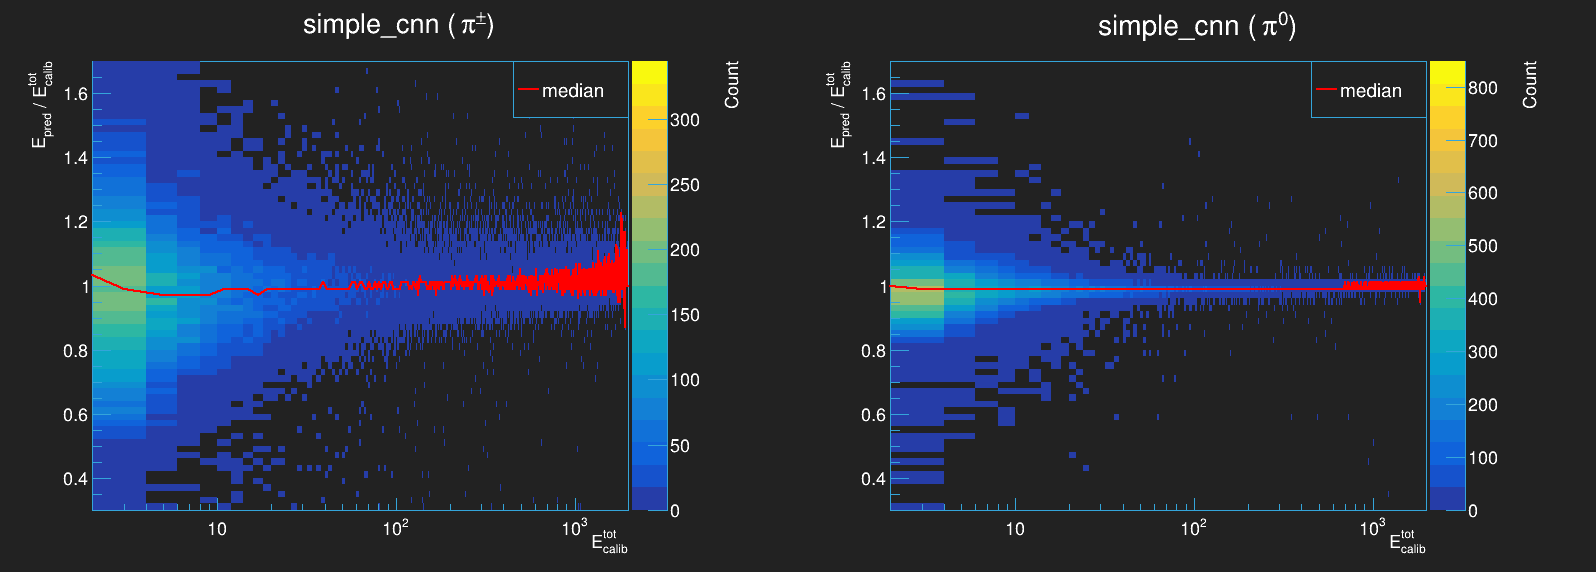

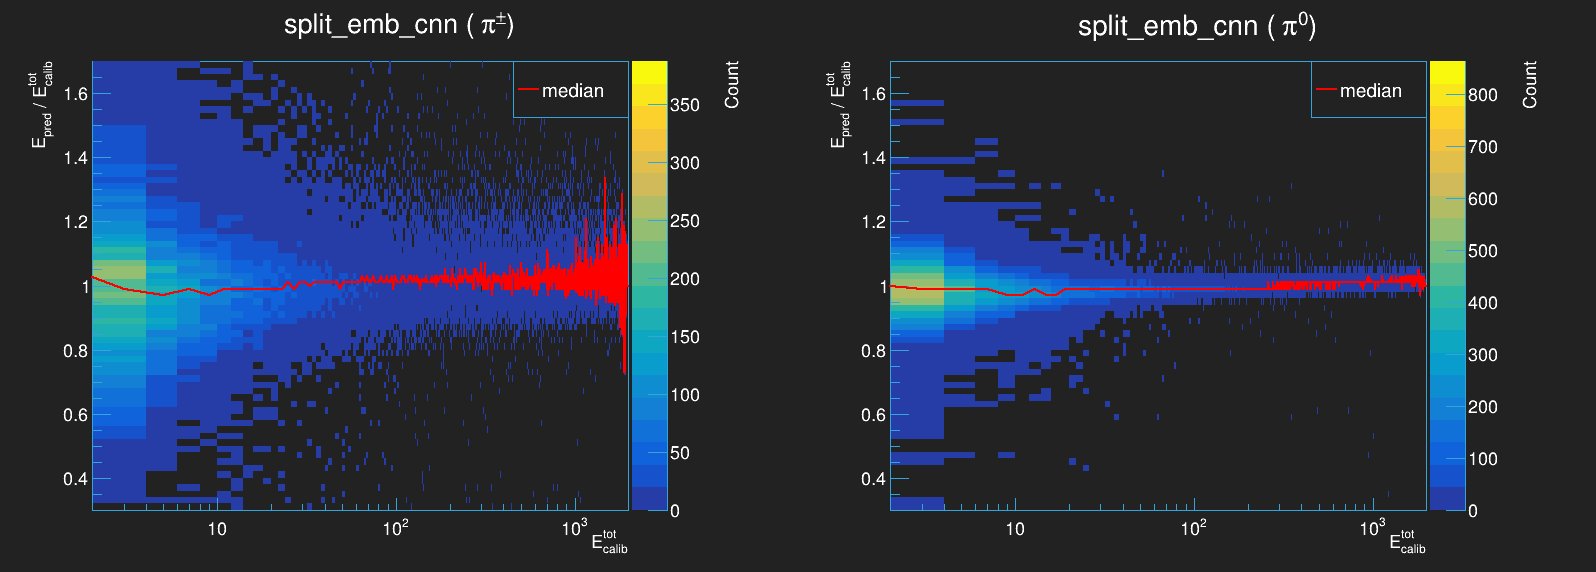

In [6]:
hists = []
curves = []

nbins = [1000,70]
title_suffix = ';E_{calib}^{tot};E_{pred} / E_{calib}^{tot};Count'

for model in ['reco','simple','simple_cnn','split_emb_cnn']:
    
    c = rt.TCanvas(qu.RN(),model,1600,600)
    c.Divide(2,1)
    
    for i,pkey in enumerate(pname.keys()):
        
        c.cd(i+1)
        
        if(model == 'reco'): curve, h = rpu.EnergyPlot2D(results[models[0]][pkey]['reco'], results[models[0]][pkey]['truth'],
                                                         title='{} ({})'.format(model, pname[pkey]) + title_suffix,
                                                         nbins = nbins
                                                        )
        
        else: curve, h = rpu.EnergyPlot2D(results[model][pkey]['output'] * results[model][pkey]['reco'], results[model][pkey]['truth'],
                                          title='{} ({})'.format(model, pname[pkey]) + title_suffix,
                                          nbins = nbins
                                         )
        
        leg = rt.TLegend(0.65,0.8,0.8,0.9)
        leg.SetTextColor(plotstyle.text)
        leg.AddEntry(curve,'median','l')
        

        h.Draw('COLZ')
        h.GetXaxis().SetRangeUser(1.0,2.0e3)
        h.GetZaxis().SetTitleOffset(1.5)
        curve.Draw('SAME')
        leg.Draw()
        rt.gPad.SetLogx()
        rt.gPad.SetLeftMargin(0.1)
        rt.gPad.SetRightMargin(0.2)
        c.Draw()
        hists.append(h)
        curves.append(curve)
        legends.append(leg)
        canvases.append(c)

### Modeling resolution via fitting

Besides the IQR, another way we can quantify resolution is by performing a Gaussian (or other?) fit in each bin, and quoting the standard deviation or FWHM.

In [7]:
# e1 is prediction, e2 is truth
def GaussianResolution(e1,e2, 
                       nbins=[100,35], x_range = (0.,2000.), y_range = (0.3,1.7), normalize=True,
                       title = 'title', x_label = 'x', y_label = 'y',
                       log_x = False, log_y = True, plotstyle = qu.PlotStyle('dark'),
                       draw_option = 'HIST C', fit_details = False):
    
    resolution = np.zeros(nbins[0])
    used_fit = np.full(nbins[0],False,dtype=bool)
    
    canvases = []
    hists = []
    funcs = []
    
    e2_nonzero = e2.copy()
    e2_nonzero[e2_nonzero == 0.] = 1.
    ratio = e1/e2_nonzero
    
    e2_bins = np.linspace(*x_range, nbins[0]+1) # gives bin edges
    ratio_binning = np.digitize(e2,e2_bins)-1
    data_lists = {i:ratio[ratio_binning == i] for i in range(nbins[0])}
    
    for i in range(nbins[0]):
        data = ratio[ratio_binning == i]
        
        if(len(data) == 0):
            if(i != 0): resolution[i] = resolution[i-1]
            else: resolution[i] = -1.
            continue
        
        # if too few data points to perform a fit, switch to interquantile range (16-84)
        if(len(data) < 5): 
            iqr = np.percentile(data,q=84) - np.percentile(data,q=16)
            if(np.isnan(iqr)): iqr = 0
            resolution[i] = iqr / np.median(data)
            hists.append(0)
            funcs.append(0)
            continue
                    
        c = rt.TCanvas(qu.RN(),'',300,300)
        
        # make a histogram
        h = rt.TH1F(qu.RN(), '', nbins[1], *y_range)
        h.SetLineColor(plotstyle.curve)
        for entry in data: h.Fill(entry)
            
        # make a function to fit to the histogram
        func_name = qu.RN()
        func = rt.TF1(func_name, 'gaus(0)', *y_range)
        func.SetLineColor(plotstyle.text)
        func.SetLineWidth(1)
        
        fit = h.Fit(func_name,'SQMCWW')
        
        h.Draw()
        fit.Draw('SAME')

        resolution[i] = func.GetParameter(2) / func.GetParameter(1)
        used_fit[i] = True
        
    # Make a plot of the resolution
    
    res_hist = rt.TH1F(qu.RN(),'{};{};{}'.format(title,x_label,y_label),nbins[0],*x_range)
    res_hist.SetLineColor(plotstyle.curve)
    for i,res in enumerate(resolution): res_hist.SetBinContent(i+1,res)
        
    return res_hist

  FUNCTION VALUE DOES NOT SEEM TO DEPEND ON ANY OF THE 3 VARIABLE PARAMETERS.
          VERIFY THAT STEP SIZES ARE BIG ENOUGH AND CHECK FCN LOGIC.
 *******************************************************************************
 *******************************************************************************
  FUNCTION VALUE DOES NOT SEEM TO DEPEND ON ANY OF THE 3 VARIABLE PARAMETERS.
          VERIFY THAT STEP SIZES ARE BIG ENOUGH AND CHECK FCN LOGIC.
 *******************************************************************************
 *******************************************************************************
  FUNCTION VALUE DOES NOT SEEM TO DEPEND ON ANY OF THE 3 VARIABLE PARAMETERS.
          VERIFY THAT STEP SIZES ARE BIG ENOUGH AND CHECK FCN LOGIC.
 *******************************************************************************
 *******************************************************************************
  FUNCTION VALUE DOES NOT SEEM TO DEPEND ON ANY OF THE 3 VARIABLE PARAMET

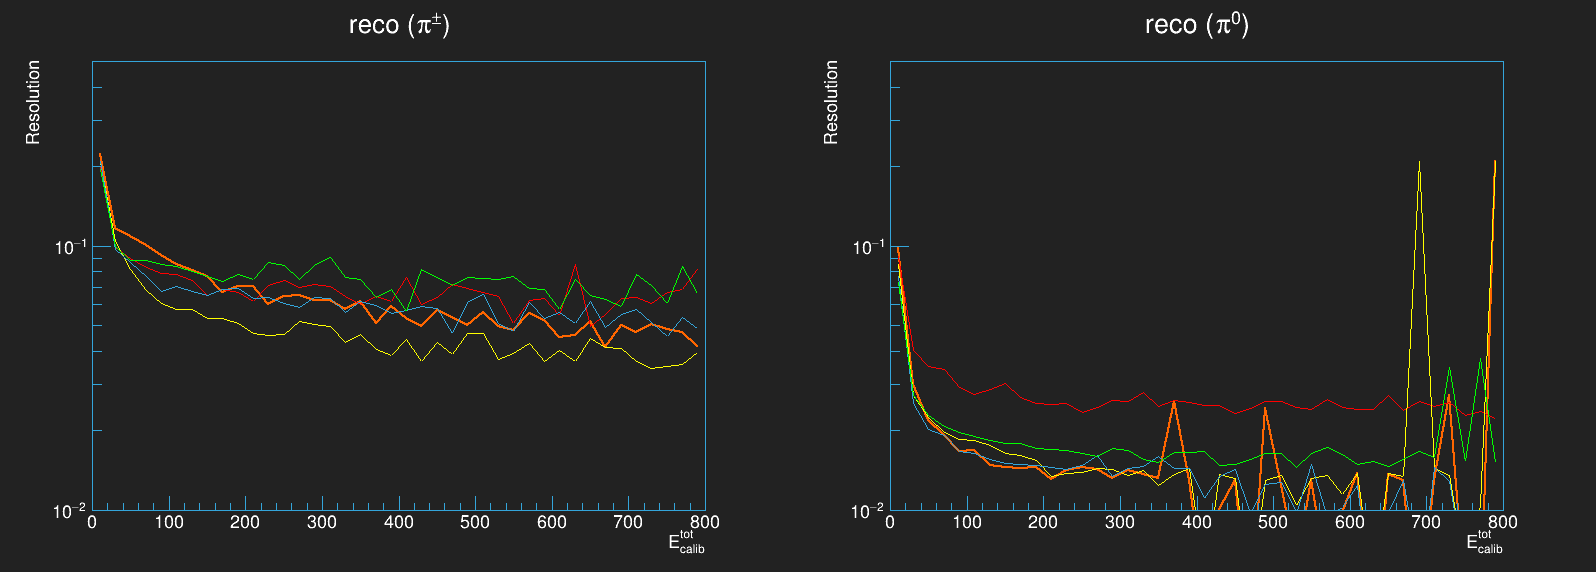

In [8]:
c = rt.TCanvas(qu.RN(),'',1600,600)
leg = rt.TLegend(0.7,0.7,0.9,0.9)
leg.SetTextColor()
c.Divide(2,1)
for i,model in enumerate(plot_keys):
    for j,key in enumerate(pname.keys()):
        
        if(model == 'reco'):
            h = GaussianResolution(
                e1 = results[models[0]][key]['reco'], e2 = results[models[0]][key]['truth'],
                nbins = [40,35], x_range=(0.,800.),
                title = '{} ({})'.format(model,pname[key]),
                x_label = 'E_{calib}^{tot}', y_label = 'Resolution',
                draw_option = ''
            )
            h.SetLineWidth(2)
        else:
            h = GaussianResolution(
                e1 = results[model][key]['output'] * results[model][key]['reco'], e2 = results[model][key]['truth'],
                nbins = [100,35],
                title = '{} ({})'.format(model,pname[key]),
                x_label = 'E_{calib}^{tot}', y_label = 'Resolution',
                draw_option = ''
            )
        h.SetLineColor(colors[i])
        c.cd(j+1)
        h.Draw('HIST SAME L')
        rt.gPad.SetLogy()
        h.SetMinimum(1.0e-2)
        h.SetMaximum(5.0e-1)
        hists.append(h)
canvases.append(c)
c.Draw()